# Lentes múltiples

En esta sección trataremos las lentes múltiples para dar una visión más general del fenomenos de las lentes gravitatorias.

El notebook se basa en los códigos disponibles en el GitHub (https://github.com/maxmen/LensingLectures) creado por Massimo Meneghetti.

## Deflexión

La ecuación de la deflexión del ángulo que hemos obtenido en la aproximación de lente fina ha sido

$$
\hat\alpha_{GR} \approx \frac{4 G M}{c^2 \xi^2} \vec{\xi}.
$$

Esta ecuación nos permite ver que la dependencia de la masa es lineal. Gracias a eso podemos utilizar el principio de superposición para sumar la desviación que genera cada lente y encontrar la deflexión total que genera una serie de lentes:

\begin{equation}
    \hat{\vec\alpha}(\xi)=\frac{4G}{c^2}\sum_i \frac{M_i}{|\vec\xi_i-\vec\xi|^2}(\vec\xi_i-\vec\xi)
\end{equation}

En el ejemplo concreto que ponemos a continuación Massimo Meneghetti utiliza una distribución aleatoria de lentes y calcula la deflexión que generan en el centro de la imagen.

Adicionalmente, se asume que todas las masas pesan lo mismo y la longitu del vector se reescala para que siempre valga 0.1.

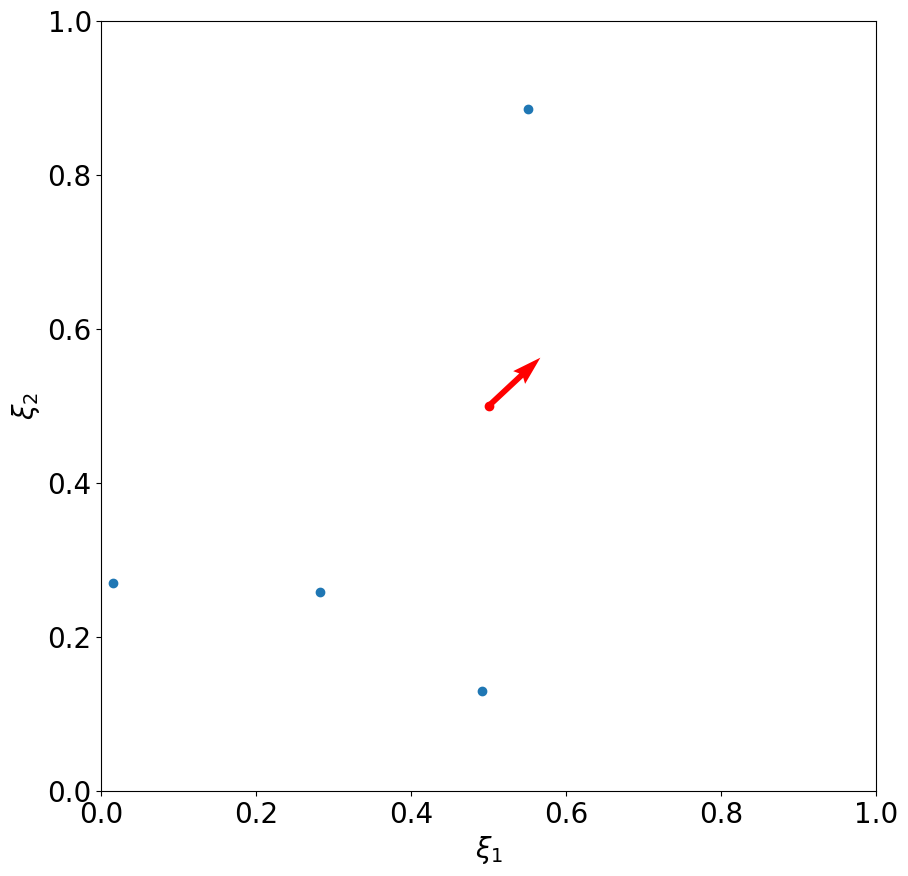

In [1]:
# generate a random distribution of point masses
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as rn
from astropy import constants as const
from astropy import units as u


# number of point lenses: you can play with this number!
n=4


#################
# distribute lenses at random positions in a region of 1pc x 1pc
xi_1=rn.rand(n)*u.pc
xi_2=rn.rand(n)*u.pc

# assign to all lenses the same mass (1 Msun)
m=np.ones(n)*const.M_sun.to('kg')

# now set the ray position at (0.5pc,0.5pc)
xi_1r=0.5*u.pc
xi_2r=0.5*u.pc

# compute distances from xr,yr
xi1=(xi_1r-xi_1).to('m')
xi2=(xi_2r-xi_2).to('m')

#print ((4.0*const.G/const.c**2*m/const.R_sun)*u.rad.to('arcsec'))#180.0/np.pi*3600.0)

rl2=(xi1**2+xi2**2).to('m2')

al1=(4.0*const.G/const.c**2*m/rl2*xi1).sum().value
al2=(4.0*const.G/const.c**2*m/rl2*xi2).sum().value
f=1e10#1e-2/np.sqrt(al1**2+al2**2)

fig,ax=plt.subplots(1,1,figsize=(10,10))
ax.plot(xi_1,xi_2,'o',zorder=-1)
ax.plot(xi_1r,xi_2r,'o',color='red')
ax.quiver(xi_1r.value, xi_2r.value, al1*f, al2*f, color='r', scale=0.1)
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.set_xlabel(r'$\xi_1$',fontsize=20)
ax.set_ylabel(r'$\xi_2$',fontsize=20)
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)


## Superficies de retardo temporal

Este notebook es una adaptación del notebook de Massimo Menegghetti que se puede encontrar en el siguiente GitHub: (https://github.com/maxmen/LensingLectures)

In [3]:
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 25}

import matplotlib
from mpl_toolkits.mplot3d import Axes3D
matplotlib.rc('font', **font)

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.ndimage import map_coordinates
import pylab
import astropy.io.fits as pyfits
from scipy.ndimage import map_coordinates
import numpy.fft as fftengine


# the parent class
class gen_lens(object):
    def __init__(self):
        self.pot_exists=False
    
    # geometrical time delay: proportional to (theta-beta)**2
    def t_geom_surf(self, beta=None):
        # this is a method to create a mesh of coordinates (x,y)
        # note that x,y vary between 0 and npix*pixel
        x = np.arange(0, self.npix, 1, float)*self.pixel
        y = x[:,np.newaxis]
        # if there is a source at beta, compute its coordinates (x0,y0)
        # it no source position is provided, set the position at the center of the grid
        if beta is None:
            x0 = y0 = self.npix / 2*self.pixel
        else:
            x0 = beta[0]+self.npix/2*self.pixel
            y0 = beta[1]+self.npix/2*self.pixel
        # now we can compute the geometrical time delay surface:
        return 0.5*((x-x0)*(x-x0)+(y-y0)*(y-y0))
    
    # gravitational time delay: this is just the lensing potential (times -1)
    def t_grav_surf(self):
        return -self.pot
    
    # total time delay: computed by summing the geometrical and the gravitational time delays
    def t_delay_surf(self,beta=None):
        t_grav=self.t_grav_surf()
        t_geom=self.t_geom_surf(beta)
        td=(t_grav+t_geom)
        return(t_grav+t_geom)
    
    # convergence: computed from the laplacian of the lensing potential 
    def convergence(self):
        if (self.pot_exists):
            kappa=0.5*(self.a11+self.a22)
        else:
            print ("The lens potential is not initialized yet")
            
        return(kappa)
    
    #shear: computed from other combinantions of the lensing potential
    def shear(self):
        if (self.pot_exists):
            g1=0.5*(self.a11-self.a22)
            g2=self.a12
        else:
            print ("The lens potential is not initialized yet")
        return(g1,g2)
    
    # determinant of the Jacobian matrix
    def detA(self):
        if (self.pot_exists):
            deta=(1.0-self.a11)*(1.0-self.a22)-self.a12*self.a21
        else:
            print ("The lens potential is not initialized yet")
        return(deta)
    
    # critical lines overlaid to the map of detA, returns a set of contour objects
    def crit_lines(self,ax=None,show=True):
        if (ax==None): 
            print ("specify the axes to display the critical lines")
        else:
            deta=self.detA()
            #ax.imshow(deta,origin='lower')
            cs=ax.contour(deta,levels=[0.0],colors='white',alpha=0.0)
            if show==False:
                ax.clear()
        return(cs)
    
    # plot of the critical lines
    def clines(self,ax=None,color='red',alpha=1.0,lt='-',fontsize=15):
        cs=self.crit_lines(ax=ax,show=False)
        contour=cs.collections[0]
        p=contour.get_paths()
        sizevs=np.empty(len(p),dtype=int)
        
        no=self.pixel
        # if we found any contour, then we proceed
        if (sizevs.size > 0):
            for j in range(len(p)):
                # for each path, we create two vectors containing 
                #the x1 and x2 coordinates of the vertices
                vs = contour.get_paths()[j].vertices 
                sizevs[j]=len(vs)
                x1=[]
                x2=[]
                for i in range(len(vs)):
                    xx1,xx2=vs[i]
                    x1.append(float(xx1))
                    x2.append(float(xx2))
        
                # plot the results!
                ax.plot((np.array(x1)-self.npix/2.)*no,
                        (np.array(x2)-self.npix/2.)*no,lt,color=color,alpha=alpha)
        ax.set_xlabel(r'$\theta_1$',fontsize=fontsize)
        ax.set_ylabel(r'$\theta_2$',fontsize=fontsize)
    
    # plot of the caustics
    def caustics(self,ax=None,alpha=1.0,color='red',lt='-',fontsize=15):
        cs=self.crit_lines(ax=ax,show=True)
        contour=cs.collections[0]
        p=contour.get_paths() # p contains the paths of each individual 
                              # critical line
        sizevs=np.empty(len(p),dtype=int)
        
        # if we found any contour, then we proceed
        if (sizevs.size > 0):
            for j in range(len(p)):
                # for each path, we create two vectors containing 
                # the x1 and x2 coordinates of the vertices
                vs = contour.get_paths()[j].vertices 
                sizevs[j]=len(vs)
                x1=[]
                x2=[]
                for i in range(len(vs)):
                    xx1,xx2=vs[i]
                    x1.append(float(xx1))
                    x2.append(float(xx2))
                # these are the points we want to map back on the source plane. 
                # To do that we need to evaluate the deflection angle at their positions
                # using scipy.ndimage.interpolate.map_coordinates we perform a bi-linear interpolation
                a_1=map_coordinates(self.a1, [[x2],[x1]],order=1)
                a_2=map_coordinates(self.a2, [[x2],[x1]],order=1)
        
                # now we can make the mapping using the lens equation:
                no=self.pixel
                y1=(x1-a_1[0]-self.npix/2.)*no
                y2=(x2-a_2[0]-self.npix/2.)*no
        
                # plot the results!
                #ax.plot((np.array(x1)-npix/2.)*no*f,(np.array(x2)-npix/2.)*no*f,'-')
                ax.plot(y1,y2,lt,color=color,alpha=alpha)
            ax.set_xlabel(r'$\beta_1$',fontsize=fontsize)
            ax.set_ylabel(r'$\beta_2$',fontsize=fontsize)
                
    # display the time delay surface
    def show_surface(self,surf0,ax=None,minx=-25,miny=-25,vmax=2,rstride=1,
                     cstride=1,cmap=plt.get_cmap('Paired'),
                     linewidth=0, antialiased=False,alpha=0.2,fontsize=20,offz=0.0):
        
        surf=surf0+offz
        if ax==None:
            print ("specify the axes with 3d projection to display the surface")
        else:
            xa=np.arange(-self.npix/2, self.npix/2, 1)
            ya=np.arange(-self.npix/2, self.npix/2, 1)
        # I will show the contours levels projected in the x-y plane
            levels=np.linspace(np.amin(surf),np.amax(surf),40)

            minx=minx
            maxx=-minx

            miny=miny
            maxy=-miny

            pixel_size=self.size/(self.npix-1)
            X, Y = np.meshgrid(xa*pixel_size, ya*pixel_size)
            ax.plot_surface(X,Y,surf,vmax=vmax,rstride=rstride, cstride=cstride, cmap=cmap,
                       linewidth=linewidth, antialiased=antialiased,alpha=alpha)

            cset = ax.contour(X, Y, surf, zdir='z', 
                               offset=np.amin(surf)-20.0, cmap=cmap,levels=levels)
            deta=self.detA()
            cset = ax.contour(X, Y, deta, zdir='z', 
                               offset=np.amin(surf)-20.0, colors='black',levels=[0])            
            cset = ax.contour(X, Y, surf, zdir='x', offset=minx, cmap=cmap,levels=[0])
            cset = ax.contour(X, Y, surf, zdir='y', offset=maxy, cmap=cmap,levels=[0])
            ax.set_xlim3d(minx, maxx)
            ax.set_ylim3d(miny, maxy)
            ax.set_zlim3d(np.amin(surf)-20.0, 10)
            ax.set_xlabel(r'$\theta_1$',fontsize=fontsize)
            ax.set_ylabel(r'$\theta_2$',fontsize=fontsize)
            ax.set_aspect('auto')            

    # display the time delay contours
    def show_contours(self,surf0,ax=None,minx=-25,miny=-25,cmap=plt.get_cmap('Paired'),
                     linewidth=1,fontsize=20,nlevels=40,levmax=100,offz=0.0):
        if ax==None:
            print ("specify the axes to display the contours")
        else:
            minx=minx
            maxx=-minx
            miny=miny
            maxy=-miny
            surf=surf0-np.min(surf0)
            levels=np.linspace(np.min(surf),levmax,nlevels)
            ax.contour(surf, cmap=cmap,levels=levels,
                       linewidth=linewidth,
                       extent=[-self.size/2,self.size/2,-self.size/2,self.size/2])
            ax.set_xlim(minx, maxx)
            ax.set_ylim(miny, maxy)
            ax.set_xlabel(r'$\theta_1$',fontsize=fontsize)
            ax.set_ylabel(r'$\theta_2$',fontsize=fontsize)
            ax.set_aspect('equal')    

# child class PSIE
class psie(gen_lens):
    def __init__(self,size=100.0,npix=200,**kwargs):
        
        if ('theta_c' in kwargs):
            self.theta_c=kwargs['theta_c']
        else:
            self.theta_c=0.0
            
        if ('ell' in kwargs):
            self.ell=kwargs['ell']
        else:
            self.ell=0.0
            
        if ('norm' in kwargs):
            self.norm=kwargs['norm']
        else: 
            self.norm=1.0
            
        self.size=size
        self.npix=npix
        self.pixel=float(self.size)/float((self.npix-1))
        self.potential()
        
    # lensing potential for the PSIE model
    def potential(self):
        x = np.arange(0, self.npix, 1, float)
        y = x[:,np.newaxis]
        x0 = y0 = self.npix / 2
        no=self.pixel**2
        self.pot_exists=True
        pot=np.sqrt(((x-x0)*self.pixel)**2/(1-self.ell)
                         +((y-y0)*self.pixel)**2*(1-self.ell)
                         +self.theta_c**2)*self.norm
        self.pot=pot
        # deflection angles are obtained by taking the gradient of psi
        self.a2,self.a1=np.gradient(self.pot/self.pixel**2)
        
        # taking the gradient of the two components of the potential is equivalent to 
        # taking the second derivatives of the potential, which will be used to compute 
        # convergence, shear and then det A, critical lines and caustics
        self.a12,self.a11=np.gradient(self.a1)
        self.a22,self.a21=np.gradient(self.a2)

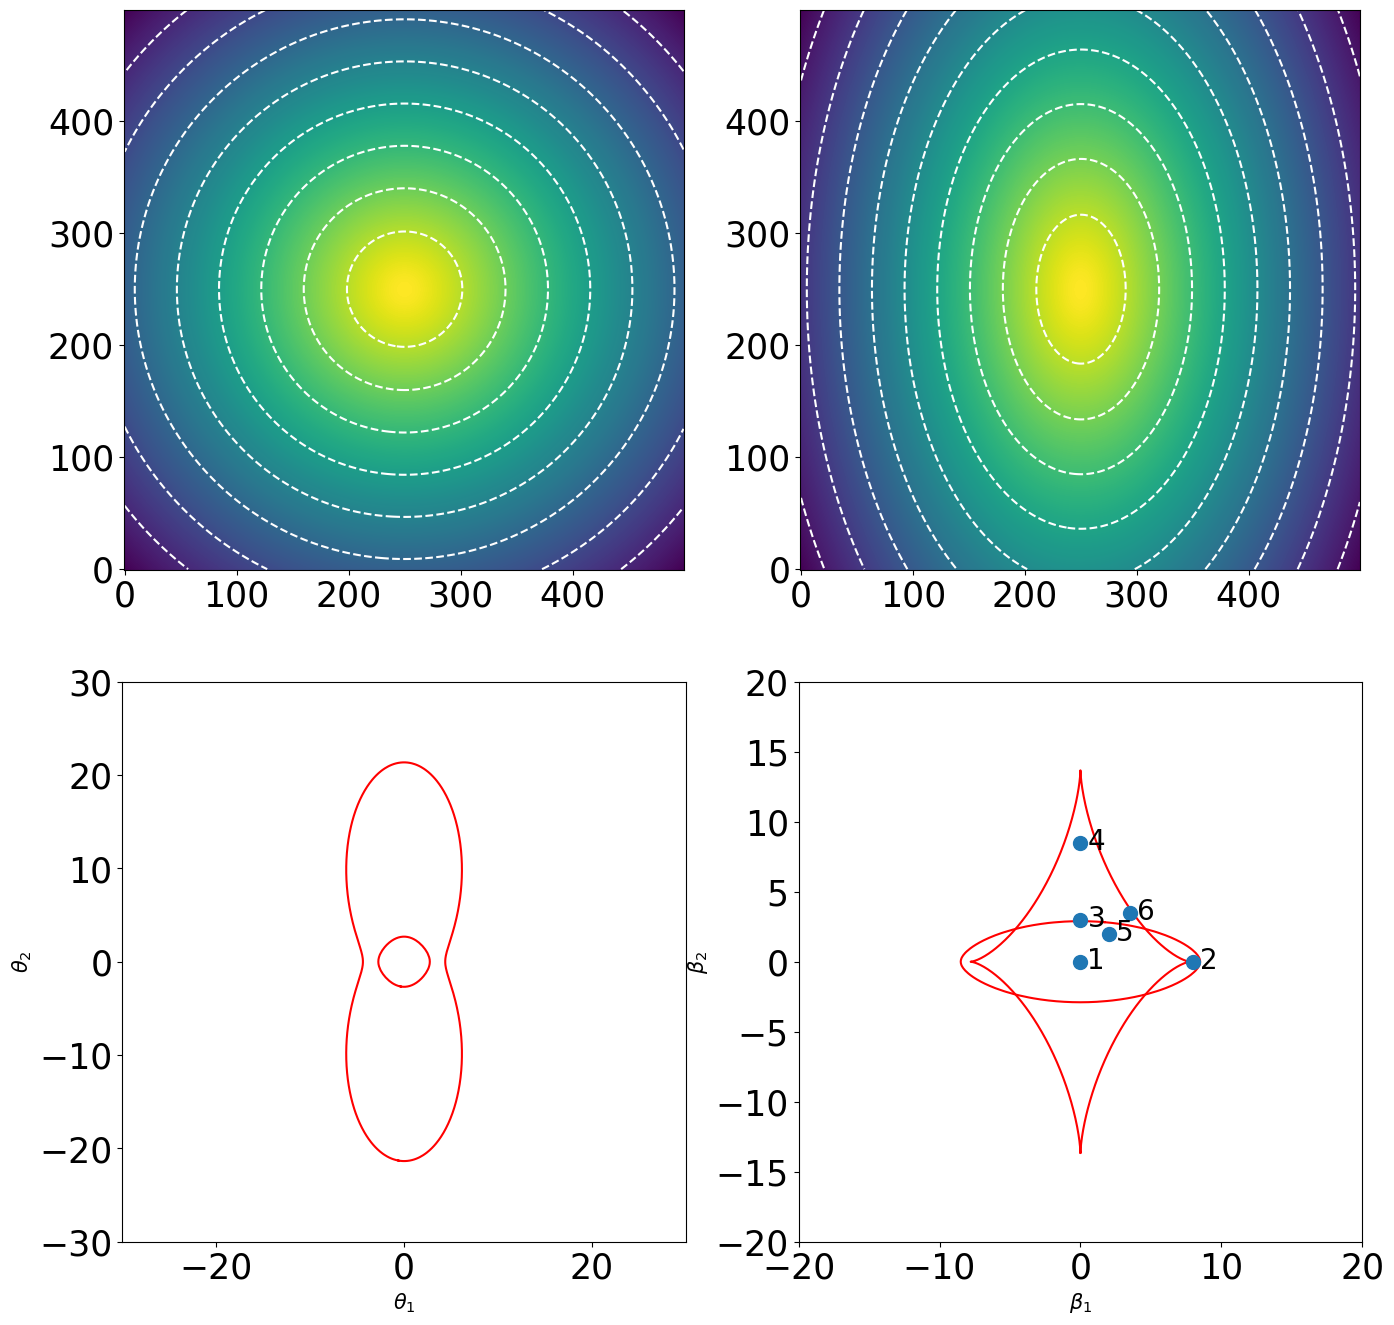

In [4]:

%matplotlib inline

# We create a map of 500x500 pixels, which is 60 (arcsec) wide on the side
size=60.
npix=500.

# Now we create a lens belonging to the class psie. The lens is defined by two parameters 
# the first is theta_c (the core radius) and the second is norm (which is a parameter which quantifies
# how big is the lens -- for example what is its mass)
# 
# The first lens (cl) we create has zero ellipticty:
kwargs={'theta_c': 2.0, 'norm': 10.0, 'ell': 0.0}
cl=psie(size=size,npix=npix,**kwargs)

# then we create a lens with ellipticity 0.4, and we call it el:
kwargs={'theta_c': 2.0, 'norm': 10.0, 'ell': 0.4}
el=psie(size=size,npix=npix,**kwargs)


# for both the lenses we can use the method t_grav_surf to compute the gravitational time delay surface,
# which is basically the minus the lensing potential:
t_grav_surf0=cl.t_grav_surf()
t_grav_surf=el.t_grav_surf()


# now we create a plot showing the time delay surfaces for the lenses cl and el. For clarity, we also display
# some contours that show that the maps of the potentials are truly circular and elliptical for the two lenses.
# These two maps will appear in a couple of panels in the upper part of the figure we are creating.

l0=np.linspace(t_grav_surf0.min(),t_grav_surf0.max(),10)

fig,ax=plt.subplots(2,2,figsize=(16,16)) # note that the figure is composed of 2x2 panels
ax[0,0].imshow(t_grav_surf0,origin='lower') # grav. time delay of lens cl in the upper left panel
ax[0,1].imshow(t_grav_surf,origin='lower')  # grav. time delay of lens el in the upper right panel
ax[0,0].contour(t_grav_surf0,levels=l0,colors='white')
ax[0,1].contour(t_grav_surf,levels=l0,colors='white')

# In the bottom panels, we are going to show the critical lines and the caustics of the lenses. As we know, 
# the caustics are lines on the source plane. For the following part of the exercise, we place 6 point sources
# at some specific positions near the caustics
el.clines(ax=ax[1,0])
el.caustics(ax=ax[1,1])
ax[1,0].set_xlim([-30,30])
ax[1,0].set_ylim([-30,30])
ax[1,1].set_xlim([-20,20])
ax[1,1].set_ylim([-20,20])

betax=[0,8,0,0,2,3.5]
betay=[0,0,3,8.5,2,3.5]
labels=['1','2','3','4','5','6']
ax[1,1].plot(betax,betay,'o',markersize=10)
for i, txt in enumerate(labels):
    ax[1,1].annotate(txt, (betax[i]+0.5,betay[i]-0.5),fontsize=20)